In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.linear_model import LogisticRegression

from tools import Modelisation, columns_cat, columns_quant, datasets

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 48)

**Définition des variables quantitatives, des variables catégorielles et des datasets :**

In [3]:
print("Columns_quant :")
display(columns_quant)
print("\nColumns_cat :")
display(columns_cat)

X_quant, X_quant_scaled, X_cat, X_cat_scaled, X_quant_cat, X_quant_cat_scaled, y = datasets(df)

Columns_quant :


['contextid',
 'campaignctrlast24h',
 'dayssincelastvisitdouble',
 'ltf_nbglobaldisplay_4w',
 'ltf_nbpartnerdisplayssincelastclick',
 'ltf_nbpartnerdisplay_90d',
 'ltf_nbpartnerclick_90d',
 'ltf_nbpartnersales_90d',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'display_size',
 'zonecostineuro']


Columns_cat :


['display_env',
 'target_env',
 'campaignscenario',
 'campaignvertical',
 'is_interstitial',
 'device_type',
 'hour',
 'weekday']


Nombre de variables pour X_quant : 13



Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro'],
      dtype='object')


Nombre de variables pour X_cat : 50



Index(['display_env_app_ios', 'display_env_other', 'display_env_web',
       'target_env_2', 'campaignscenario_5', 'campaignscenario_6',
       'campaignscenario_11', 'campaignscenario_12', 'campaignscenario_13',
       'campaignscenario_17', 'campaignvertical_20.0', 'campaignvertical_23.0',
       'campaignvertical_129.0', 'campaignvertical_200002.0',
       'is_interstitial_True', 'device_type_Desktop',
       'device_type_Desktop - Safari', 'device_type_Mobile - Other',
       'device_type_Unknown', 'device_type_iPad', 'device_type_iPhone',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday'],
      dtype='object')


Nombre de variables pour X_quant_cat : 63


Afin de comparer nos modèles en termes de performances brutes et de temps d'exécution, il est fondamental de déterminer quelques métriques de référence. Ici, il faut surtout faire en sorte d'éviter de prédire des non-clics qui seraient en réalité des clics (ie prédire trop de 0), quitte à prédire trop de 1. Autrement dit, il faut maximiser le recall et le NPV (Negative predictive value) afin de limiter les erreurs de type II. Le F1 Score, combinaison du recall et de la précision, est également pertinent. 

# Régression logistique
## Variables quantitatives

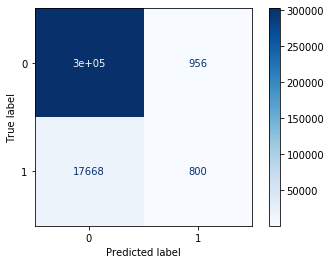

f1 : 0.0791
recall : 0.0433
negative predictive value : 0.9448
precision : 0.4556
roc_auc : 0.7373


In [4]:
m = Modelisation(X_quant, y, LogisticRegression(), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

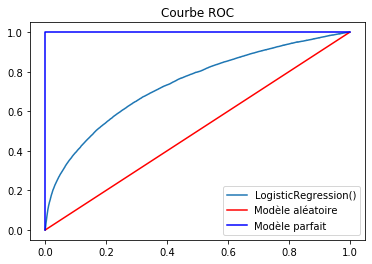

In [5]:
m.show_ROC()

In [6]:
coeff_df = pd.DataFrame(np.transpose(m.model.coef_), X_quant.columns, columns=['Coefficient'])
coeff_df

,Coefficient
contextid,-0.027361
campaignctrlast24h,0.362738
dayssincelastvisitdouble,-0.029115
ltf_nbglobaldisplay_4w,0.011195
ltf_nbpartnerdisplayssincelastclick,-0.023198
ltf_nbpartnerdisplay_90d,-0.009613
ltf_nbpartnerclick_90d,0.032866
ltf_nbpartnersales_90d,-0.010938
nbdayssincelastclick,-0.108391
nbdisplay_1hour,-0.218325


In [7]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant

X_ = add_constant(X_quant)
print(Logit(y, X_).fit().summary())

Optimization terminated successfully.
         Current function value: 0.197126
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:     is_display_clicked   No. Observations:              1610494
Model:                          Logit   Df Residuals:                  1610480
Method:                           MLE   Df Model:                           13
Date:                Wed, 17 Feb 2021   Pseudo R-squ.:                 0.09804
Time:                        13:31:11   Log-Likelihood:            -3.1747e+05
converged:                       True   LL-Null:                   -3.5198e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -3.7845      0.0

Avec LASSO (+ univariate mais variable déjà exclue par Lasso): 

In [8]:
X1 = df[['contextid',
         'zonecostineuro',
         'campaignctrlast24h',
         'ltf_nbpartnerclick_90d',
         'nbdisplay_1hour',
         'nbdayssincelastclick',
         'display_size',
         'nbdisplayglobalapprox_1d_sum_xdevice']]
y1 = df['is_display_clicked']

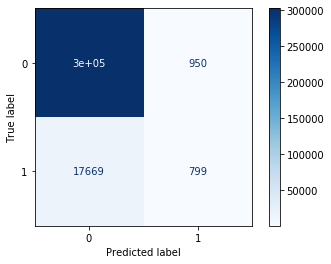

f1 : 0.0790
recall : 0.0433
negative predictive value : 0.9448
precision : 0.4568
roc_auc : 0.7371


In [9]:
m1 = Modelisation(X1, y1, LogisticRegression(), scaling=True)
m1.show_conf_matrix()
m1.show_metrics_score()

## Categorical variables

In [10]:
# Nombre de valeurs distinctes
for column in columns_cat:
    print(f"{column} : {len(set(df[column]))}")

display_env : 4
target_env : 2
campaignscenario : 7
campaignvertical : 34
is_interstitial : 3
device_type : 7
hour : 24
weekday : 7


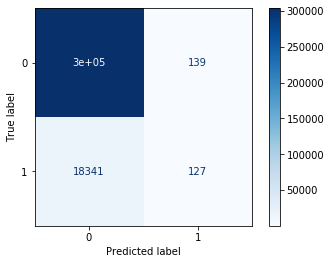

f1 : 0.0136
recall : 0.0069
negative predictive value : 0.9430
precision : 0.4774
roc_auc : 0.6852


In [11]:
m = Modelisation(X_cat, y, LogisticRegression(), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

## Quantitative + categorical

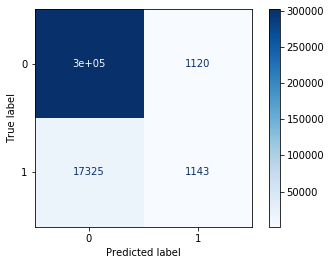

f1 : 0.1103
recall : 0.0619
negative predictive value : 0.9458
precision : 0.5051
roc_auc : 0.7539
Wall time: 17.6 s


In [12]:
%%time
m = Modelisation(X_quant_cat, y, LogisticRegression(), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

Avec RFECV :

In [13]:
X2 = X_quant_cat[['zonecostineuro',
         'campaignctrlast24h',
         'nbdisplay_1hour',
         'nbdayssincelastclick',
         'display_size',
         'is_interstitial_True',
         'device_type_Desktop',
         'device_type_iPhone',
         'display_env_app_ios',
         'target_env_2',
         'campaignscenario_13']]
y2 = df['is_display_clicked']

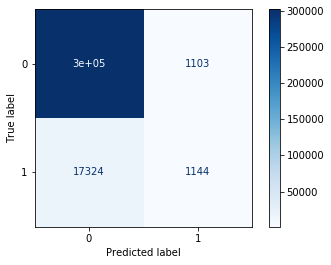

f1 : 0.1105
recall : 0.0619
negative predictive value : 0.9458
precision : 0.5091
roc_auc : 0.7510
Wall time: 5.43 s


In [14]:
%%time
m2 = Modelisation(X2, y2, LogisticRegression(), scaling=True)
m2.show_conf_matrix()
m2.show_metrics_score()

## Comparaison par rapport aux valeurs de C 

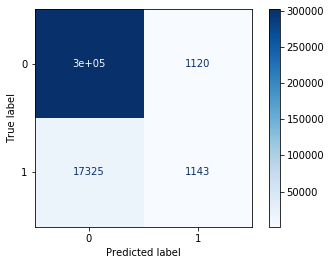

f1 : 0.1103
recall : 0.0619
negative predictive value : 0.9458
precision : 0.5051
roc_auc : 0.7539


In [15]:
m = Modelisation(X_quant_cat, y, LogisticRegression(C=0.2), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

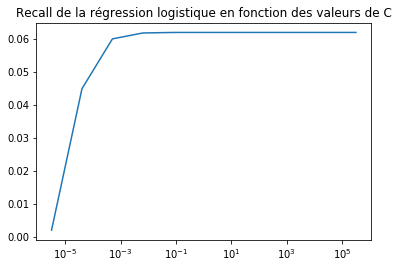

Wall time: 2min 49s


In [16]:
%%time
C, list_recall = [], []
for c in np.logspace(-5.5, 5.5, num=11): 
    m = Modelisation(X_quant_cat, y, LogisticRegression(C=c), scaling=True)
    C.append(c)
    list_recall.append(m.recall)
plt.plot(C, list_recall)
plt.xscale('log')
plt.title("Recall de la régression logistique en fonction des valeurs de C")
plt.show()

# Régression logistique sur la base sur-échantillonnée

In [17]:
df1 = pd.read_csv('data/df_train_prepro_res.csv').sample(frac=1)
df1.shape

(3024152, 22)

In [18]:
X_res_quant, X_res_quant_scaled, X_res_cat, X_res_cat_scaled, X_res_quant_cat, X_res_quant_cat_scaled, y_res = datasets(df1)


Nombre de variables pour X_quant : 13



Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro'],
      dtype='object')


Nombre de variables pour X_cat : 50



Index(['display_env_app_ios', 'display_env_other', 'display_env_web',
       'target_env_2', 'campaignscenario_5', 'campaignscenario_6',
       'campaignscenario_11', 'campaignscenario_12', 'campaignscenario_13',
       'campaignscenario_17', 'campaignvertical_20.0', 'campaignvertical_23.0',
       'campaignvertical_129.0', 'campaignvertical_200002.0',
       'is_interstitial_True', 'device_type_Desktop',
       'device_type_Desktop - Safari', 'device_type_Mobile - Other',
       'device_type_Unknown', 'device_type_iPad', 'device_type_iPhone',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday'],
      dtype='object')


Nombre de variables pour X_quant_cat : 63


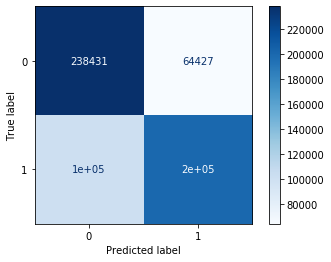

f1 : 0.7076
recall : 0.6643
negative predictive value : 0.7017
precision : 0.7569
roc_auc : 0.8020
Wall time: 40.5 s


In [19]:
%%time
m = Modelisation(X_res_quant_cat, y_res, LogisticRegression(), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

In [20]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:06:29
